# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"]/5 # * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1861.7666015625
iteration 0 loss 57.827980041503906


iteration 5000 loss 0.1362142413854599


iteration 10000 loss 0.06926476210355759


iteration 15000 loss 0.0373506098985672


iteration 20000 loss 0.027251943945884705


iteration 25000 loss 0.13288502395153046


iteration 30000 loss 0.015583088621497154


iteration 35000 loss 0.012578165158629417


iteration 40000 loss 0.011030953377485275


iteration 45000 loss 0.028570115566253662


iteration 50000 loss 0.010601820424199104


iteration 55000 loss 0.007212987169623375


iteration 60000 loss 1.2020787000656128


iteration 65000 loss 0.012432218529284


iteration 70000 loss 0.005277616903185844


iteration 75000 loss 0.004848563112318516


iteration 80000 loss 0.004566473886370659


iteration 85000 loss 0.012144198641180992


iteration 90000 loss 0.004211066290736198


iteration 95000 loss 0.016765503212809563


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 0.003559279255568981


iteration 105000 loss 0.0029419963248074055


iteration 110000 loss 0.03876834735274315


iteration 115000 loss 0.002397543750703335


iteration 120000 loss 0.0022235626820474863


iteration 125000 loss 0.008069033734500408


iteration 130000 loss 0.0019485222874209285


iteration 135000 loss 0.001828230102546513


iteration 140000 loss 0.0017277812585234642


iteration 145000 loss 0.0016360785812139511


iteration 150000 loss 0.0015568851958960295


iteration 155000 loss 0.0014832071028649807


iteration 160000 loss 0.0014108020113781095


iteration 165000 loss 0.008525355719029903


iteration 170000 loss 0.001288228784687817


iteration 175000 loss 0.0012659539934247732


iteration 180000 loss 0.01637226529419422


iteration 185000 loss 0.0011324312072247267


iteration 190000 loss 0.0026159698609262705


iteration 195000 loss 0.0010480160126462579


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 0.0010064460802823305


iteration 205000 loss 0.000982247176580131


iteration 210000 loss 0.0009486971539445221


iteration 215000 loss 0.0009145831572823226


iteration 220000 loss 0.000884758192114532


iteration 225000 loss 0.0008563818992115557


iteration 230000 loss 0.0008296578889712691


iteration 235000 loss 0.0008035623468458652


iteration 240000 loss 0.0007792385877110064


iteration 245000 loss 0.000755657849367708


iteration 250000 loss 0.0007334038382396102


iteration 255000 loss 0.0007359906448982656


iteration 260000 loss 0.0006918824510648847


iteration 265000 loss 0.0006733579793944955


iteration 270000 loss 0.0006540000904351473


iteration 275000 loss 0.0006364803411997855


iteration 280000 loss 0.0006186207756400108


iteration 285000 loss 0.000602695916313678


iteration 290000 loss 0.000586867390666157


iteration 295000 loss 0.0005708712851628661


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 0.0005560163408517838


iteration 305000 loss 0.000546669471077621


iteration 310000 loss 0.0005335373571142554


iteration 315000 loss 0.0005208924412727356


iteration 320000 loss 0.0005087927565909922


iteration 325000 loss 0.0004970347508788109


iteration 330000 loss 0.0004853813152294606


iteration 335000 loss 0.00047357691801153123


iteration 340000 loss 0.0004626238369382918


iteration 345000 loss 0.0004522814997471869


iteration 350000 loss 0.00044237799011170864


iteration 355000 loss 0.0004323426110204309


iteration 360000 loss 0.00042303360532969236


iteration 365000 loss 0.00041430711280554533


iteration 370000 loss 0.0004054475575685501


iteration 375000 loss 0.00039586631464771926


iteration 380000 loss 0.00038760004099458456


iteration 385000 loss 0.0003793702635448426


iteration 390000 loss 0.0003714199410751462


iteration 395000 loss 0.00036407035076990724


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 0.0003563241334632039


iteration 405000 loss 0.0003500237362459302


iteration 410000 loss 0.00034234358463436365


iteration 415000 loss 0.00033480324782431126


iteration 420000 loss 0.00032815313898026943


iteration 425000 loss 0.0003208963025826961


iteration 430000 loss 0.0003139586769975722


iteration 435000 loss 0.0003072783292736858


iteration 440000 loss 0.0003010388172697276


iteration 445000 loss 0.00029497669311240315


iteration 450000 loss 0.0002891456533689052


iteration 455000 loss 0.00028333839145489037


iteration 460000 loss 0.000277714483672753


iteration 465000 loss 0.00027225451776757836


iteration 470000 loss 0.00026706632343120873


iteration 475000 loss 0.0002623285399749875


iteration 480000 loss 0.0002575887774582952


iteration 485000 loss 0.000252682832069695


iteration 490000 loss 0.0002478609385434538


iteration 495000 loss 0.0002430814492981881


L2 loss -- Plot

loss 18.786666870117188


loss -92.49752807617188


loss -169.58827209472656


loss -233.2818603515625


loss -285.86328125


loss -329.4158020019531


loss -365.6353454589844


loss -395.7898254394531


loss -420.8053894042969


loss -441.3828125


loss -458.0843200683594


loss -471.39056396484375


loss -481.7386779785156


loss -489.5439147949219


loss -495.20751953125


loss -499.118408203125


loss -501.6517333984375


loss -503.1636657714844


loss -503.9779052734375


loss -504.36444091796875


loss -504.52178955078125


loss -504.5747985839844


loss -504.5887451171875


loss -504.5914306640625


loss -504.5917663574219


loss -504.591796875


loss -504.591796875


loss -504.591796875


loss -504.591796875


loss -504.591796875


loss -504.59185791015625


loss -504.591796875


loss -504.5918273925781


loss -504.591796875


loss -504.591796875


loss -504.591796875


loss -504.591796875


loss -504.591796875


loss -504.591796875


loss -504.591796875


final mse:  3.7028499710878293e-10
max, min: 7.0888577 -7.8752685
loss 18.786666870117188


loss -95.66842651367188


loss -172.93563842773438


loss -236.7836151123047


loss -289.73748779296875


loss -333.6986083984375


loss -370.34088134765625


loss -401.018798828125


loss -426.72119140625


loss -448.15557861328125


loss -465.86151123046875


loss -480.2700500488281


loss -491.7333984375


loss -500.566162109375


loss -507.0948791503906


loss -511.6838684082031


loss -514.7255859375


loss -516.6077880859375


loss -517.6796875


loss -518.22998046875


loss -518.4774169921875


loss -518.571044921875


loss -518.5992431640625


loss -518.6055908203125


loss -518.6065673828125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


loss -518.606689453125


final mse:  2.2356828888181468e-10
max, min: 7.636709 -8.041344


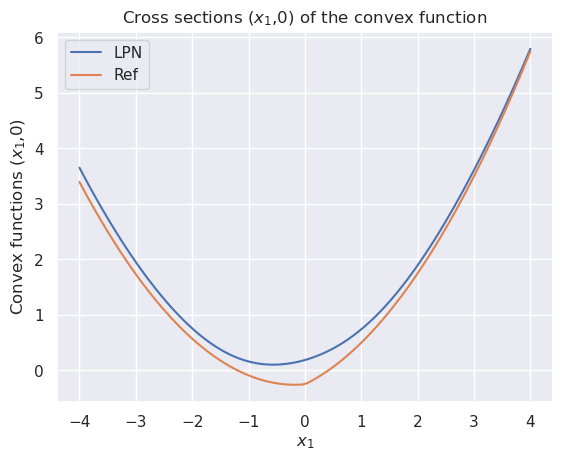

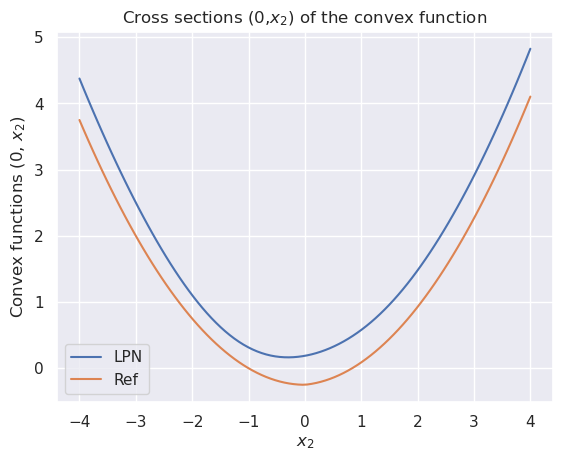

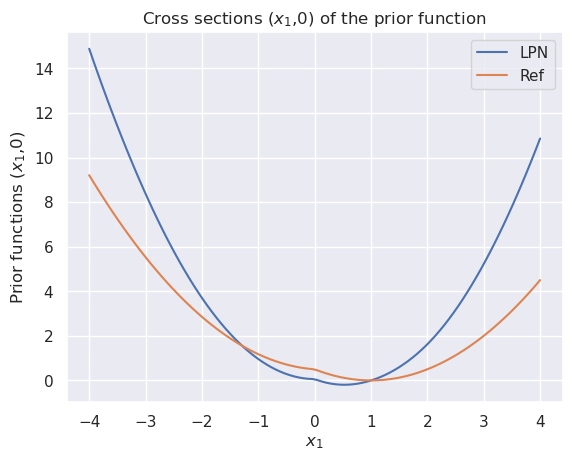

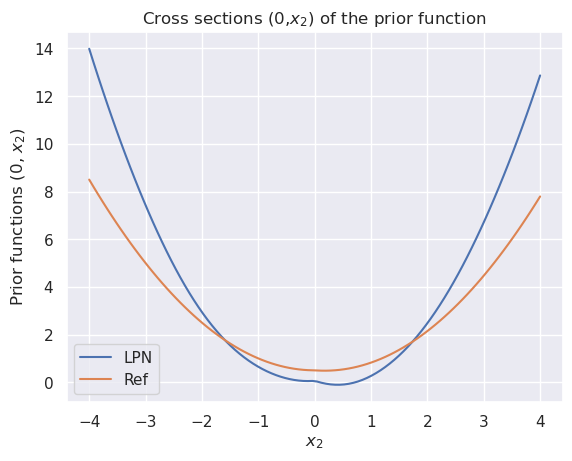

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN  ---
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


# --- Train 2nd LPN 
print("\n--- Training Second LPN for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] / 5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN for Concave Quadratic Prior ---
iteration 0 loss 1726.76513671875
iteration 0 loss 540.2627563476562


iteration 5000 loss 0.27200770378112793


iteration 10000 loss 0.08822491765022278


iteration 15000 loss 0.21411922574043274


iteration 20000 loss 0.04973714053630829


iteration 25000 loss 0.04551394656300545


iteration 30000 loss 0.03285384923219681


iteration 35000 loss 0.03033868968486786


iteration 40000 loss 0.02555602602660656


iteration 45000 loss 0.021968308836221695


iteration 50000 loss 0.21355120837688446


iteration 55000 loss 0.018470339477062225


iteration 60000 loss 0.01696019619703293


iteration 65000 loss 0.014830125495791435


iteration 70000 loss 0.014008126221597195


iteration 75000 loss 0.023311451077461243


iteration 80000 loss 0.011966091580688953


iteration 85000 loss 0.014202670194208622


iteration 90000 loss 0.012955429032444954


iteration 95000 loss 0.2622082829475403


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 0.009077677503228188


iteration 105000 loss 0.008150489069521427


iteration 110000 loss 0.007508210372179747


iteration 115000 loss 0.007006113417446613


iteration 120000 loss 0.006572115700691938


iteration 125000 loss 0.006188107188791037


iteration 130000 loss 0.00585569441318512


iteration 135000 loss 0.005553405731916428


iteration 140000 loss 0.005287818145006895


iteration 145000 loss 0.005028739105910063


iteration 150000 loss 0.0048159100115299225


iteration 155000 loss 0.004596764221787453


iteration 160000 loss 0.004409227520227432


iteration 165000 loss 0.004216934088617563


iteration 170000 loss 0.004087929613888264


iteration 175000 loss 0.0038885516114532948


iteration 180000 loss 0.003763727843761444


iteration 185000 loss 0.0036024206783622503


iteration 190000 loss 0.003476047422736883


iteration 195000 loss 0.0033351199235767126


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 0.0032279049046337605


iteration 205000 loss 0.003144345013424754


iteration 210000 loss 0.0030307921115309


iteration 215000 loss 0.002925392473116517


iteration 220000 loss 0.0028242527041584253


iteration 225000 loss 0.0027293418534100056


iteration 230000 loss 0.0026389274280518293


iteration 235000 loss 0.002552763558924198


iteration 240000 loss 0.0024713147431612015


iteration 245000 loss 0.002394140465185046


iteration 250000 loss 0.0023189594503492117


iteration 255000 loss 0.002248457632958889


iteration 260000 loss 0.0021820992697030306


iteration 265000 loss 0.0021191095001995564


iteration 270000 loss 0.002056362573057413


iteration 275000 loss 0.001996284117922187


iteration 280000 loss 0.0019391864771023393


iteration 285000 loss 0.0018847644096240401


iteration 290000 loss 0.0018328549340367317


iteration 295000 loss 0.0017807594267651439


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 0.0017332774586975574


iteration 305000 loss 0.0016992260934785008


iteration 310000 loss 0.001653008977882564


iteration 315000 loss 0.0016096762847155333


iteration 320000 loss 0.001571941189467907


iteration 325000 loss 0.0015319198137149215


iteration 330000 loss 0.0014948624884709716


iteration 335000 loss 0.0014579633716493845


iteration 340000 loss 0.0014240887248888612


iteration 345000 loss 0.0013899283949285746


iteration 350000 loss 0.0013586764689534903


iteration 355000 loss 0.0013274232624098659


iteration 360000 loss 0.0012974399141967297


iteration 365000 loss 0.001267582061700523


iteration 370000 loss 0.0012384685687720776


iteration 375000 loss 0.0012101156171411276


iteration 380000 loss 0.0011829816503450274


iteration 385000 loss 0.0011562276631593704


iteration 390000 loss 0.0011314047733321786


iteration 395000 loss 0.001107625081203878


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 0.0010834533022716641


iteration 405000 loss 0.0010664525907486677


iteration 410000 loss 0.001042669638991356


iteration 415000 loss 0.0010197387309744954


iteration 420000 loss 0.0009957088623195887


iteration 425000 loss 0.0009739839588291943


iteration 430000 loss 0.0009524873457849026


iteration 435000 loss 0.0009316991781815886


iteration 440000 loss 0.0009119460009969771


iteration 445000 loss 0.0008936095982789993


iteration 450000 loss 0.0008756067836657166


iteration 455000 loss 0.0008574829553253949


iteration 460000 loss 0.0008403125684708357


iteration 465000 loss 0.0008232855470851064


iteration 470000 loss 0.0008073241915553808


iteration 475000 loss 0.0007916926988400519


iteration 480000 loss 0.0007765214540995657


iteration 485000 loss 0.0007616998045705259


iteration 490000 loss 0.0007473425939679146


iteration 495000 loss 0.000733241147827357


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


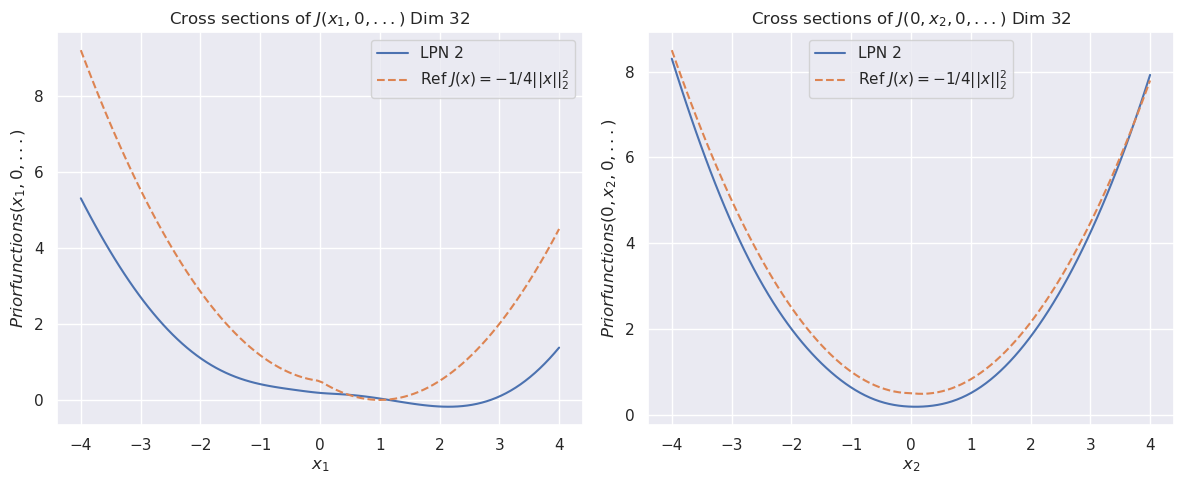

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)